In [ ]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip uninstall tensorflow tensorflow-cpu tensorflow-gpu -y

Found existing installation: tensorflow 2.20.0
Uninstalling tensorflow-2.20.0:
Uninstalling tensorflow-2.20.0:
  Successfully uninstalled tensorflow-2.20.0
  Successfully uninstalled tensorflow-2.20.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install tensorflow-macos
%pip install tensorflow-metal
%pip install tensorflow
# Note: after installing macOS TensorFlow/Metal packages, restart the kernel so TensorFlow picks up the Metal plugin

ERROR: Could not find a version that satisfies the requirement tensorflow-macos (from versions: none)
ERROR: No matching distribution found for tensorflow-macos
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement tensorflow-metal (from versions: none)
ERROR: No matching distribution found for tensorflow-metal
ERROR: Could not find a version that satisfies the requirement tensorflow-metal (from versions: none)
ERROR: No matching distribution found for tensorflow-metal
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached tensorflow-2.20.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (4.5 kB)
Using cached tensorflow-2.20.0-cp313-cp313-macosx_12_0_arm64.whl (200.7 MB)
  Using cached tensorflow-2.20.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (4.5 kB)
Using c

In [9]:
# Cell 1 — imports, GPU check, seeds
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, cohen_kappa_score,
                             matthews_corrcoef, roc_curve, auc)
import itertools
import math
import sys
print("Python:", sys.version)
print("TensorFlow:", tf.__version__)

# Device detection & MPS (macOS) handling
import platform
plat = platform.system()
print('Platform:', plat, platform.machine())
# List all physical devices
physical_devices = tf.config.list_physical_devices()
print('Physical devices:', physical_devices)
if plat == 'Darwin':
    # On macOS, prefer TensorFlow-Metal (Apple's Metal Performance Shaders)
    try:
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            for dev in gpus:
                try:
                    tf.config.experimental.set_memory_growth(dev, True)
                except Exception as e:
                    print('Could not set memory growth for device', dev, ':', e)
            print('Using Metal (MPS) backend devices:', gpus)
        else:
            print('No GPU (Metal) devices found. Install tensorflow-macos + tensorflow-metal to enable MPS support.')
    except Exception as e:
        print('Error configuring Metal devices:', e)
else:
    # non-macOS: handle traditional GPUs (CUDA)
    gpus = tf.config.list_physical_devices('GPU')
    print('GPUs:', gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print('GPU memory growth set.')
        except Exception as e:
            print('Could not set memory growth:', e)

# Determinism / seeds (best effort)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


Python: 3.13.7 (v3.13.7:bcee1c32211, Aug 14 2025, 19:10:51) [Clang 16.0.0 (clang-1600.0.26.6)]
TensorFlow: 2.20.0
Platform: Darwin arm64
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
No GPU (Metal) devices found. Install tensorflow-macos + tensorflow-metal to enable MPS support.


In [10]:
# Cell 2 — file locate (tries common Kaggle and /mnt/data)
candidate_paths = [
    "/content/vista_sequences.fasta"
    "/kaggle/input/vista-sequence/vista_sequences.fasta",
    "Vista_Dataset/vista_sequences.fasta",
    "/mnt/data/vista_sequence.fasta",
    "/kaggle/working/vista_sequence.fasta",
    "/kaggle/input/vista-enhancers/vista_sequence.fasta",
]
fasta_path = "/content/vista_sequences.fasta"
for p in candidate_paths:
    if os.path.exists(p):
        fasta_path = p
        break
if fasta_path is None:
    raise FileNotFoundError(f"vista_sequence.fasta not found. Tried paths:\n" + "\n".join(candidate_paths))
print("Using fasta file:", fasta_path)


Using fasta file: Vista_Dataset/vista_sequences.fasta


In [11]:
# Cell 3 — parse FASTA and build dataframe
def parse_fasta_to_records(path):
    # Expect fasta headers to include label/species; if not, you may need to adapt to your fasta header format.
    records = []
    with open(path, 'r') as fh:
        header = None
        seq_lines = []
        for line in fh:
            line=line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if header is not None:
                    seq = "".join(seq_lines).upper()
                    records.append((header, seq))
                header = line[1:]
                seq_lines = []
            else:
                seq_lines.append(line)
        # last
        if header is not None:
            seq = "".join(seq_lines).upper()
            records.append((header, seq))
    return records

records = parse_fasta_to_records(fasta_path)
print("Parsed sequences:", len(records))
# Inspect a few headers to ensure label extraction
for h,s in records[:5]:
    print("H:", h)


Parsed sequences: 3408
H: Human|chr16:86430087-86430726 | element 1 | positive  | neural tube[12/12] | hindbrain (rhombencephalon)[12/12] | limb[3/12] | cranial nerve[8/12]
H: Human|chr16:85620095-85621736 | element 2 | negative
H: Human|chr16:80423343-80424652 | element 3 | negative
H: Human|chr16:80372593-80373755 | element 4 | positive  | neural tube[6/10] | hindbrain (rhombencephalon)[10/10] | midbrain (mesencephalon)[10/10]
H: Human|chr16:79969907-79971297 | element 5 | negative


In [12]:
# Cell 4 — build dataframe with label extraction (try to infer from header)
rows = []
for header, seq in records:
    h = header.lower()
    # Best-effort inference:
    if "human" in h or "hs" in h:
        species = "human"
    elif "mouse" in h or "mm" in h:
        species = "mouse"
    else:
        # fallback: if file has species in separate field, split by '|' or whitespace:
        species = "unknown"
    # enhancer presence detection:
    if "enhancer" in h or "positive" in h or "pos" in h:
        enhancer_flag = 1
    elif "non" in h or "negative" in h or "neg" in h or "not" in h:
        enhancer_flag = 0
    else:
        # fallback: try numeric statuses
        enhancer_flag = None
    rows.append({"header": header, "sequence": seq, "species": species, "enhancer": enhancer_flag})

df = pd.DataFrame(rows)
print(df.shape)
df['seq_len'] = df['sequence'].str.len()
df.seq_len.describe()
# If many 'unknown' or enhancer None, print sample to let user confirm header format:
print(df['species'].value_counts(dropna=False))
print("Enhancer flag counts:", df['enhancer'].value_counts(dropna=False))
df.head(8)


(3408, 4)
species
human    2002
mouse    1406
Name: count, dtype: int64
Enhancer flag counts: enhancer
1    1750
0    1658
Name: count, dtype: int64


,header,sequence,species,enhancer,seq_len
0,Human|chr16:86430087-86430726 | element 1 | po...,AACTGAAGGGACCCCGTTAGCATATAAACAAAAGGTGGGGGGTAGC...,human,1,640
1,Human|chr16:85620095-85621736 | element 2 | ne...,GGCCCTGGTATGTTTGTTCTTCCAGGGGCTCCCAGGATGGATCCAG...,human,0,1642
2,Human|chr16:80423343-80424652 | element 3 | ne...,AAGATTGCCATTTGGGGTGTTTCTTGGGGCTAAGAACCATGAAGAC...,human,0,1310
3,Human|chr16:80372593-80373755 | element 4 | po...,GTGACAGAGACAGACAGTGACAGAGACAGATTTTAGAATTTGAACA...,human,1,1163
4,Human|chr16:79969907-79971297 | element 5 | ne...,TGACACCCACTATTATCCAGTCCTTGATAAACCTCTTTATTTGTTC...,human,0,1391
5,Human|chr16:79949950-79951518 | element 6 | ne...,AGTCACCCAGGTGGTAGTGGGCTGCAGATGCTGTGGGTTTTGTTTC...,human,0,1569
6,Human|chr16:79026563-79028162 | element 7 | ne...,ACAGAAGCCTCAAGCCTAACCAACAAGAAAGATCACTTCATATGCA...,human,0,1600
7,Human|chr16:78933253-78934686 | element 9 | ne...,TTGTTCCGGAAACCTAACTCCAAATCTTTGAACTTCCTAGAAACCT...,human,0,1434


In [13]:
# Cell 5 — filter & prepare labels for scenarios
# Scenario 1: only enhancer sequences (paper's first scenario predicted human vs mouse among enhancers).
df_enhancers = df[df['enhancer']==1].copy()
print("Enhancer sequences (for scenario1):", len(df_enhancers))

# Scenario 2: all sequences -> classes: human_enhancer, mouse_enhancer, no_enhancer
def class_label_row(r):
    if r.enhancer==1 and r.species=="human":
        return 0  # human enhancer
    if r.enhancer==1 and r.species=="mouse":
        return 1  # mouse enhancer
    return 2      # no enhancer

df['class_s2'] = df.apply(class_label_row, axis=1)
print(df['class_s2'].value_counts())


Enhancer sequences (for scenario1): 1750
class_s2
2    1658
0    1029
1     721
Name: count, dtype: int64


In [14]:
# Cell 6 — encoding schemes
INT_MAP = {'A':1,'C':3,'G':2,'T':4,'N':0}
ATOMIC_MAP = {'A':70,'C':58,'G':78,'T':66,'N':0}
EIIP_MAP = {'A':0.1260,'C':0.1340,'G':0.0806,'T':0.1335,'N':0.0}

# BFDNA: per-sequence frequencies (the paper uses for each base the frequency across the whole sequence;
# then every position mapped to that base's frequency value).
def encode_sequence_integer(seq):
    return [INT_MAP.get(b,0) for b in seq]

def encode_sequence_atomic(seq):
    return [ATOMIC_MAP.get(b,0) for b in seq]

def encode_sequence_eiip(seq):
    return [EIIP_MAP.get(b,0.0) for b in seq]

def encode_sequence_bfdna(seq):
    L = len(seq)
    # count bases
    counts = {'A':0,'C':0,'G':0,'T':0}
    for b in seq:
        if b in counts:
            counts[b]+=1
    freqs = {b: (counts[b]/L if L>0 else 0.0) for b in counts}
    # map each position to its base frequency value (paper example uses this)
    return [freqs.get(b,0.0) for b in seq]

ENCODERS = {
    'integer': encode_sequence_integer,
    'atomic': encode_sequence_atomic,
    'eiip': encode_sequence_eiip,
    'bfdna': encode_sequence_bfdna
}


In [15]:
# Cell 7 — prepare encoded arrays, pad sequences to max_len and min-max normalize per scheme
from tensorflow.keras.preprocessing.sequence import pad_sequences
def prepare_encoded_array(seqs, encoder_name, max_len_cap=2000):
    """Encode and pad sequences; truncate to max_len_cap to avoid OOM."""
    enc = ENCODERS[encoder_name]
    encoded = [enc(s) for s in seqs]
    # Cap very long sequences
    if max_len_cap:
        encoded = [x[:max_len_cap] for x in encoded]
    max_len = max(len(x) for x in encoded)
    padded = pad_sequences(encoded, maxlen=max_len, dtype='float32',
                           padding='post', truncating='post', value=0.0)
    # Min–max normalize across dataset
    minv, maxv = padded.min(), padded.max()
    if maxv > minv:
        padded = (padded - minv) / (maxv - minv)
    return padded, max_len

# Example for BFDNA
X_bfdna, maxlen_bfdna = prepare_encoded_array(df['sequence'].tolist(), 'bfdna')
print("BFDNA shape", X_bfdna.shape, "maxlen", maxlen_bfdna)


BFDNA shape (3408, 2000) maxlen 2000


In [16]:
# Cell 8 — helper: metric computations used in paper (CSI, G-mean)
def classification_metrics(y_true, y_pred, average='binary'):
    # y_true: 1d labels
    # y_pred: 1d predicted labels
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    # compute confusion matrix elements (for binary)
    if average=='binary' or len(np.unique(y_true))==2:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        # CSI = Precision + TPR - 1 (paper definition)
        tpr = tp/(tp+fn) if (tp+fn)>0 else 0.0
        csi = prec + tpr - 1
        specificity = tn/(tn+fp) if (tn+fp)>0 else 0.0
        gmean = math.sqrt(rec * specificity)
    else:
        # for multiclass, compute macro variants:
        csi = None
        gmean = None
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    return {'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'CSI':csi, 'G-mean':gmean, 'MCC':mcc, 'Kappa':kappa}

# multiclass macro-average ROC AUC:
def multiclass_roc_auc_score(y_true, y_proba, average="macro"):
    # y_true integer labels, y_proba: N x C
    try:
        return roc_auc_score(to_categorical(y_true), y_proba, average=average, multi_class='ovr')
    except Exception as e:
        print("roc_auc_score error:", e)
        return None


In [17]:
# Cell 9 — model builders (scenario1: binary, scenario2: multiclass)
def build_bilstm_scenario1(input_shape):
    inp = layers.Input(shape=input_shape)

    # --- CNN block (learn local motifs first) ---
    x = layers.Conv1D(64, kernel_size=7, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(128, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # --- BiLSTM block (learn long dependencies) ---
    x = layers.Bidirectional(layers.LSTM(64, dropout=0.3, return_sequences=False))(x)

    # --- Dense classifier ---
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    out = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model


def build_bilstm_scenario2(input_shape, n_classes):
    inp = layers.Input(shape=input_shape)

    # --- CNN block ---
    x = layers.Conv1D(64, kernel_size=7, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(128, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # --- BiLSTM block ---
    x = layers.Bidirectional(layers.LSTM(64, dropout=0.3))(x)

    # --- Dense classifier ---
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    out = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model



In [18]:
# Cell 10 — training helper to train and evaluate a model; returns history and metrics
def train_and_evaluate_model(X, y, scenario=1, encoder_name='bfdna', batch_size=32, epochs=100):
    # X: padded 2D array (samples, seq_len). We'll reshape to (samples, seq_len, 1)
    X3 = np.expand_dims(X, -1)
    if scenario == 1:
        # binary: y are species labels for enhancer-only samples (human=0, mouse=1)
        y_bin = y  # should be 0/1
        X_train, X_temp, y_train, y_temp = train_test_split(X3, y_bin, test_size=0.30, random_state=SEED, stratify=y_bin)
        # split temp into val/test equally: 0.15 each of full
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)
        model = build_bilstm_scenario1(input_shape=X3.shape[1:])
        opt = optimizers.RMSprop()
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    else:
        # multi-class: y are 0..C-1
        n_classes = len(np.unique(y))
        y_cat = to_categorical(y, num_classes=n_classes)
        X_train, X_temp, y_train, y_temp = train_test_split(X3, y_cat, test_size=0.30, random_state=SEED, stratify=y)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=np.argmax(y_temp, axis=1))
        model = build_bilstm_scenario2(input_shape=X3.shape[1:], n_classes=n_classes)
        model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

    # Callbacks
    outdir = f"./outputs/{encoder_name}/scenario{scenario}"
    os.makedirs(outdir, exist_ok=True)
    ckpt = callbacks.ModelCheckpoint(os.path.join(outdir, "best_model.h5"), monitor='val_loss', save_best_only=True, verbose=1)
    csvlog = callbacks.CSVLogger(os.path.join(outdir, "training_log.csv"))
    # Paper trained full 500 epochs — we avoid EarlyStopping to be faithful, but you can enable it.
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[ckpt, csvlog], verbose=2)
    # load best
    model.load_weights(os.path.join(outdir, "best_model.h5"))
    # Predict
    if scenario==1:
        y_pred_prob = model.predict(X_test).ravel()
        y_pred = (y_pred_prob >= 0.5).astype(int)
        y_true = y_test
    else:
        y_pred_prob = model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

    # metrics
    results = {}
    if scenario==1:
        auc_score = roc_auc_score(y_true, y_pred_prob)
        m = classification_metrics(y_true, y_pred, average='binary')
        m['AUC'] = auc_score
        results = m
    else:
        auc_score = multiclass_roc_auc_score(y_true, y_pred_prob)
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
        mcc = matthews_corrcoef(y_true, y_pred)
        kappa = cohen_kappa_score(y_true, y_pred)
        # For CSI and G-mean paper printed single scores; we will leave CSI/G-mean as None for multiclass (could compute per-class)
        results = {'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'CSI':None, 'G-mean':None, 'MCC':mcc, 'Kappa':kappa, 'AUC':auc_score}

    # save predictions & test y
    np.savez(os.path.join(outdir, "test_preds_and_truth.npz"), y_true=y_true, y_pred=y_pred, y_pred_prob=y_pred_prob)
    # save training history
    pd.DataFrame(history.history).to_csv(os.path.join(outdir, "history.csv"), index=False)
    return model, history, results, (X_test, y_test, y_pred, y_pred_prob)


In [19]:
# Cell 11 — full pipeline loop over encoders and both scenarios (warning: heavy; you can run one encoder at a time)
encoders = ['integer','atomic','eiip','bfdna']
all_results = {'scenario1':{}, 'scenario2':{}}
for encoder in encoders:
      print("\n\n### Encoder:", encoder)
      X, _ = prepare_encoded_array(df['sequence'].tolist(), encoder)
      # Scenario 1 uses only enhancer sequences and species labels among enhancers
      df_e = df[df['enhancer']==1].reset_index(drop=True)
      X_e, _ = prepare_encoded_array(df_e['sequence'].tolist(), encoder)
      # species mapping among enhancers:
      species_map = df_e['species'].map({'human':0,'mouse':1}).fillna(0).astype(int).values
      # Train scenario1
      print("Training Scenario 1 (human vs mouse enhancers) for encoder", encoder)
      model1, hist1, res1, testinfo1 = train_and_evaluate_model(X_e, species_map, scenario=1, encoder_name=encoder, batch_size=32, epochs = 30 if encoder == 'bfdna' else 30
  )
      all_results['scenario1'][encoder] = res1
      print("Scenario1 results:", res1)
      # Scenario2: multiclass
      print("Training Scenario 2 (human enhancer / mouse enhancer / no enhancer) for encoder", encoder)
      # class_s2 in df already (0 human enh,1 mouse enh,2 no enhancer)
      X_all, _ = prepare_encoded_array(df['sequence'].tolist(), encoder)
      classes_s2 = df['class_s2'].values
      model2, hist2, res2, testinfo2 = train_and_evaluate_model(X_all, classes_s2, scenario=2, encoder_name=encoder, batch_size=32, epochs = 30 if encoder == 'bfdna' else 30
  )
      all_results['scenario2'][encoder] = res2
      print("Scenario2 results:", res2)
      # Save intermediate results
      pd.DataFrame(all_results).to_csv(f"./outputs/{encoder}_summary_results.csv")




### Encoder: integer
Training Scenario 1 (human vs mouse enhancers) for encoder integer
Epoch 1/30
Training Scenario 1 (human vs mouse enhancers) for encoder integer
Epoch 1/30

Epoch 1: val_loss improved from None to 0.69210, saving model to ./outputs/integer/scenario1/best_model.h5

Epoch 1: val_loss improved from None to 0.69210, saving model to ./outputs/integer/scenario1/best_model.h5


39/39 - 10s - 259ms/step - accuracy: 0.6065 - loss: 0.6617 - val_accuracy: 0.5954 - val_loss: 0.6921
Epoch 2/30
Epoch 2/30

Epoch 2: val_loss improved from 0.69210 to 0.69086, saving model to ./outputs/integer/scenario1/best_model.h5

Epoch 2: val_loss improved from 0.69210 to 0.69086, saving model to ./outputs/integer/scenario1/best_model.h5


39/39 - 7s - 192ms/step - accuracy: 0.6106 - loss: 0.6476 - val_accuracy: 0.5992 - val_loss: 0.6909
Epoch 3/30
Epoch 3/30

Epoch 3: val_loss did not improve from 0.69086
39/39 - 9s - 232ms/step - accuracy: 0.6400 - loss: 0.6434 - val_accuracy: 0.5992 - val_loss: 0.6938
Epoch 4/30

Epoch 3: val_loss did not improve from 0.69086
39/39 - 9s - 232ms/step - accuracy: 0.6400 - loss: 0.6434 - val_accuracy: 0.5992 - val_loss: 0.6938
Epoch 4/30

Epoch 4: val_loss improved from 0.69086 to 0.68926, saving model to ./outputs/integer/scenario1/best_model.h5

Epoch 4: val_loss improved from 0.69086 to 0.68926, saving model to ./outputs/integer/scenario1/best_model.h5


39/39 - 10s - 257ms/step - accuracy: 0.6400 - loss: 0.6378 - val_accuracy: 0.5992 - val_loss: 0.6893
Epoch 5/30
Epoch 5/30

Epoch 5: val_loss improved from 0.68926 to 0.68033, saving model to ./outputs/integer/scenario1/best_model.h5

Epoch 5: val_loss improved from 0.68926 to 0.68033, saving model to ./outputs/integer/scenario1/best_model.h5


39/39 - 10s - 258ms/step - accuracy: 0.6531 - loss: 0.6236 - val_accuracy: 0.5992 - val_loss: 0.6803
Epoch 6/30
Epoch 6/30

Epoch 6: val_loss improved from 0.68033 to 0.67713, saving model to ./outputs/integer/scenario1/best_model.h5

Epoch 6: val_loss improved from 0.68033 to 0.67713, saving model to ./outputs/integer/scenario1/best_model.h5


39/39 - 10s - 255ms/step - accuracy: 0.6792 - loss: 0.6095 - val_accuracy: 0.6031 - val_loss: 0.6771
Epoch 7/30
Epoch 7/30

Epoch 7: val_loss did not improve from 0.67713
39/39 - 10s - 262ms/step - accuracy: 0.6849 - loss: 0.5948 - val_accuracy: 0.5992 - val_loss: 0.7016
Epoch 8/30

Epoch 7: val_loss did not improve from 0.67713
39/39 - 10s - 262ms/step - accuracy: 0.6849 - loss: 0.5948 - val_accuracy: 0.5992 - val_loss: 0.7016
Epoch 8/30

Epoch 8: val_loss did not improve from 0.67713
39/39 - 10s - 256ms/step - accuracy: 0.6939 - loss: 0.5877 - val_accuracy: 0.5992 - val_loss: 0.7022
Epoch 9/30

Epoch 8: val_loss did not improve from 0.67713
39/39 - 10s - 256ms/step - accuracy: 0.6939 - loss: 0.5877 - val_accuracy: 0.5992 - val_loss: 0.7022
Epoch 9/30

Epoch 9: val_loss did not improve from 0.67713
39/39 - 10s - 260ms/step - accuracy: 0.7110 - loss: 0.5527 - val_accuracy: 0.6031 - val_loss: 0.7057
Epoch 10/30

Epoch 9: val_loss did not improve from 0.67713
39/39 - 10s - 260ms/step - a

75/75 - 16s - 215ms/step - accuracy: 0.4591 - loss: 1.0433 - val_accuracy: 0.3933 - val_loss: 1.0750
Epoch 2/30
Epoch 2/30

Epoch 2: val_loss improved from 1.07497 to 1.06368, saving model to ./outputs/integer/scenario2/best_model.h5

Epoch 2: val_loss improved from 1.07497 to 1.06368, saving model to ./outputs/integer/scenario2/best_model.h5


75/75 - 18s - 241ms/step - accuracy: 0.4742 - loss: 1.0347 - val_accuracy: 0.4031 - val_loss: 1.0637
Epoch 3/30
Epoch 3/30

Epoch 3: val_loss improved from 1.06368 to 1.06054, saving model to ./outputs/integer/scenario2/best_model.h5

Epoch 3: val_loss improved from 1.06368 to 1.06054, saving model to ./outputs/integer/scenario2/best_model.h5


75/75 - 19s - 256ms/step - accuracy: 0.4805 - loss: 1.0202 - val_accuracy: 0.4540 - val_loss: 1.0605
Epoch 4/30
Epoch 4/30

Epoch 4: val_loss did not improve from 1.06054
75/75 - 19s - 256ms/step - accuracy: 0.4851 - loss: 1.0196 - val_accuracy: 0.4110 - val_loss: 1.0813
Epoch 5/30

Epoch 4: val_loss did not improve from 1.06054
75/75 - 19s - 256ms/step - accuracy: 0.4851 - loss: 1.0196 - val_accuracy: 0.4110 - val_loss: 1.0813
Epoch 5/30

Epoch 5: val_loss did not improve from 1.06054
75/75 - 22s - 292ms/step - accuracy: 0.4914 - loss: 1.0169 - val_accuracy: 0.4481 - val_loss: 1.0884
Epoch 6/30

Epoch 5: val_loss did not improve from 1.06054
75/75 - 22s - 292ms/step - accuracy: 0.4914 - loss: 1.0169 - val_accuracy: 0.4481 - val_loss: 1.0884
Epoch 6/30

Epoch 6: val_loss did not improve from 1.06054
75/75 - 20s - 262ms/step - accuracy: 0.4985 - loss: 1.0000 - val_accuracy: 0.4521 - val_loss: 1.1264
Epoch 7/30

Epoch 6: val_loss did not improve from 1.06054
75/75 - 20s - 262ms/step - ac

39/39 - 9s - 232ms/step - accuracy: 0.6049 - loss: 0.6702 - val_accuracy: 0.5878 - val_loss: 0.6881
Epoch 2/30
Epoch 2/30

Epoch 2: val_loss improved from 0.68805 to 0.68101, saving model to ./outputs/atomic/scenario1/best_model.h5

Epoch 2: val_loss improved from 0.68805 to 0.68101, saving model to ./outputs/atomic/scenario1/best_model.h5


39/39 - 7s - 182ms/step - accuracy: 0.6106 - loss: 0.6593 - val_accuracy: 0.5878 - val_loss: 0.6810
Epoch 3/30
Epoch 3/30

Epoch 3: val_loss improved from 0.68101 to 0.67776, saving model to ./outputs/atomic/scenario1/best_model.h5

Epoch 3: val_loss improved from 0.68101 to 0.67776, saving model to ./outputs/atomic/scenario1/best_model.h5


39/39 - 9s - 230ms/step - accuracy: 0.6090 - loss: 0.6586 - val_accuracy: 0.5878 - val_loss: 0.6778
Epoch 4/30
Epoch 4/30

Epoch 4: val_loss improved from 0.67776 to 0.66227, saving model to ./outputs/atomic/scenario1/best_model.h5

Epoch 4: val_loss improved from 0.67776 to 0.66227, saving model to ./outputs/atomic/scenario1/best_model.h5


39/39 - 10s - 253ms/step - accuracy: 0.6114 - loss: 0.6498 - val_accuracy: 0.5878 - val_loss: 0.6623
Epoch 5/30
Epoch 5/30

Epoch 5: val_loss did not improve from 0.66227
39/39 - 10s - 252ms/step - accuracy: 0.6343 - loss: 0.6472 - val_accuracy: 0.5878 - val_loss: 0.6757
Epoch 6/30

Epoch 5: val_loss did not improve from 0.66227
39/39 - 10s - 252ms/step - accuracy: 0.6343 - loss: 0.6472 - val_accuracy: 0.5878 - val_loss: 0.6757
Epoch 6/30

Epoch 6: val_loss did not improve from 0.66227
39/39 - 10s - 252ms/step - accuracy: 0.6424 - loss: 0.6451 - val_accuracy: 0.5878 - val_loss: 0.7054
Epoch 7/30

Epoch 6: val_loss did not improve from 0.66227
39/39 - 10s - 252ms/step - accuracy: 0.6424 - loss: 0.6451 - val_accuracy: 0.5878 - val_loss: 0.7054
Epoch 7/30

Epoch 7: val_loss did not improve from 0.66227
39/39 - 10s - 253ms/step - accuracy: 0.6408 - loss: 0.6385 - val_accuracy: 0.5878 - val_loss: 0.7583
Epoch 8/30

Epoch 7: val_loss did not improve from 0.66227
39/39 - 10s - 253ms/step - ac

39/39 - 10s - 253ms/step - accuracy: 0.6776 - loss: 0.6192 - val_accuracy: 0.6374 - val_loss: 0.6337
Epoch 14/30
Epoch 14/30

Epoch 14: val_loss improved from 0.63373 to 0.63217, saving model to ./outputs/atomic/scenario1/best_model.h5

Epoch 14: val_loss improved from 0.63373 to 0.63217, saving model to ./outputs/atomic/scenario1/best_model.h5


39/39 - 10s - 253ms/step - accuracy: 0.6776 - loss: 0.6037 - val_accuracy: 0.6527 - val_loss: 0.6322
Epoch 15/30
Epoch 15/30

Epoch 15: val_loss did not improve from 0.63217
39/39 - 10s - 253ms/step - accuracy: 0.6759 - loss: 0.6200 - val_accuracy: 0.6260 - val_loss: 0.6329
Epoch 16/30

Epoch 15: val_loss did not improve from 0.63217
39/39 - 10s - 253ms/step - accuracy: 0.6759 - loss: 0.6200 - val_accuracy: 0.6260 - val_loss: 0.6329
Epoch 16/30

Epoch 16: val_loss did not improve from 0.63217
39/39 - 10s - 253ms/step - accuracy: 0.6800 - loss: 0.6036 - val_accuracy: 0.6107 - val_loss: 0.6650
Epoch 17/30

Epoch 16: val_loss did not improve from 0.63217
39/39 - 10s - 253ms/step - accuracy: 0.6800 - loss: 0.6036 - val_accuracy: 0.6107 - val_loss: 0.6650
Epoch 17/30

Epoch 17: val_loss did not improve from 0.63217
39/39 - 10s - 252ms/step - accuracy: 0.6865 - loss: 0.5983 - val_accuracy: 0.6107 - val_loss: 0.6557
Epoch 18/30

Epoch 17: val_loss did not improve from 0.63217
39/39 - 10s - 25

75/75 - 16s - 217ms/step - accuracy: 0.4495 - loss: 1.0558 - val_accuracy: 0.3249 - val_loss: 1.0655
Epoch 2/30
Epoch 2/30

Epoch 2: val_loss did not improve from 1.06549
75/75 - 18s - 240ms/step - accuracy: 0.4721 - loss: 1.0406 - val_accuracy: 0.3249 - val_loss: 1.0801
Epoch 3/30

Epoch 2: val_loss did not improve from 1.06549
75/75 - 18s - 240ms/step - accuracy: 0.4721 - loss: 1.0406 - val_accuracy: 0.3249 - val_loss: 1.0801
Epoch 3/30

Epoch 3: val_loss did not improve from 1.06549
75/75 - 19s - 254ms/step - accuracy: 0.4725 - loss: 1.0327 - val_accuracy: 0.3014 - val_loss: 1.1079
Epoch 4/30

Epoch 3: val_loss did not improve from 1.06549
75/75 - 19s - 254ms/step - accuracy: 0.4725 - loss: 1.0327 - val_accuracy: 0.3014 - val_loss: 1.1079
Epoch 4/30

Epoch 4: val_loss did not improve from 1.06549
75/75 - 19s - 255ms/step - accuracy: 0.4792 - loss: 1.0311 - val_accuracy: 0.2994 - val_loss: 1.1055
Epoch 5/30

Epoch 4: val_loss did not improve from 1.06549
75/75 - 19s - 255ms/step - ac

75/75 - 19s - 255ms/step - accuracy: 0.4843 - loss: 1.0273 - val_accuracy: 0.4853 - val_loss: 1.0467
Epoch 7/30
Epoch 7/30

Epoch 7: val_loss did not improve from 1.04667
75/75 - 19s - 255ms/step - accuracy: 0.4855 - loss: 1.0288 - val_accuracy: 0.4795 - val_loss: 1.0510
Epoch 8/30

Epoch 7: val_loss did not improve from 1.04667
75/75 - 19s - 255ms/step - accuracy: 0.4855 - loss: 1.0288 - val_accuracy: 0.4795 - val_loss: 1.0510
Epoch 8/30

Epoch 8: val_loss improved from 1.04667 to 1.04573, saving model to ./outputs/atomic/scenario2/best_model.h5

Epoch 8: val_loss improved from 1.04667 to 1.04573, saving model to ./outputs/atomic/scenario2/best_model.h5


75/75 - 19s - 254ms/step - accuracy: 0.4851 - loss: 1.0233 - val_accuracy: 0.4873 - val_loss: 1.0457
Epoch 9/30
Epoch 9/30

Epoch 9: val_loss improved from 1.04573 to 1.04415, saving model to ./outputs/atomic/scenario2/best_model.h5

Epoch 9: val_loss improved from 1.04573 to 1.04415, saving model to ./outputs/atomic/scenario2/best_model.h5


75/75 - 19s - 255ms/step - accuracy: 0.4855 - loss: 1.0272 - val_accuracy: 0.4873 - val_loss: 1.0441
Epoch 10/30
Epoch 10/30

Epoch 10: val_loss did not improve from 1.04415
75/75 - 19s - 255ms/step - accuracy: 0.4876 - loss: 1.0244 - val_accuracy: 0.4873 - val_loss: 1.0538
Epoch 11/30

Epoch 10: val_loss did not improve from 1.04415
75/75 - 19s - 255ms/step - accuracy: 0.4876 - loss: 1.0244 - val_accuracy: 0.4873 - val_loss: 1.0538
Epoch 11/30

Epoch 11: val_loss did not improve from 1.04415
75/75 - 19s - 254ms/step - accuracy: 0.4864 - loss: 1.0259 - val_accuracy: 0.4873 - val_loss: 1.0524
Epoch 12/30

Epoch 11: val_loss did not improve from 1.04415
75/75 - 19s - 254ms/step - accuracy: 0.4864 - loss: 1.0259 - val_accuracy: 0.4873 - val_loss: 1.0524
Epoch 12/30

Epoch 12: val_loss did not improve from 1.04415
75/75 - 19s - 254ms/step - accuracy: 0.4876 - loss: 1.0257 - val_accuracy: 0.4873 - val_loss: 1.0496
Epoch 13/30

Epoch 12: val_loss did not improve from 1.04415
75/75 - 19s - 25

75/75 - 19s - 255ms/step - accuracy: 0.4839 - loss: 1.0230 - val_accuracy: 0.4873 - val_loss: 1.0440
Epoch 14/30
Epoch 14/30

Epoch 14: val_loss improved from 1.04395 to 1.04147, saving model to ./outputs/atomic/scenario2/best_model.h5

Epoch 14: val_loss improved from 1.04395 to 1.04147, saving model to ./outputs/atomic/scenario2/best_model.h5


75/75 - 499s - 7s/step - accuracy: 0.4834 - loss: 1.0247 - val_accuracy: 0.4834 - val_loss: 1.0415
Epoch 15/30
Epoch 15/30

Epoch 15: val_loss did not improve from 1.04147
75/75 - 19s - 254ms/step - accuracy: 0.4864 - loss: 1.0204 - val_accuracy: 0.4873 - val_loss: 1.0502
Epoch 16/30

Epoch 15: val_loss did not improve from 1.04147
75/75 - 19s - 254ms/step - accuracy: 0.4864 - loss: 1.0204 - val_accuracy: 0.4873 - val_loss: 1.0502
Epoch 16/30

Epoch 16: val_loss did not improve from 1.04147
75/75 - 19s - 252ms/step - accuracy: 0.4860 - loss: 1.0220 - val_accuracy: 0.4795 - val_loss: 1.0517
Epoch 17/30

Epoch 16: val_loss did not improve from 1.04147
75/75 - 19s - 252ms/step - accuracy: 0.4860 - loss: 1.0220 - val_accuracy: 0.4795 - val_loss: 1.0517
Epoch 17/30

Epoch 17: val_loss did not improve from 1.04147
75/75 - 19s - 252ms/step - accuracy: 0.4864 - loss: 1.0202 - val_accuracy: 0.4344 - val_loss: 1.0621
Epoch 18/30

Epoch 17: val_loss did not improve from 1.04147
75/75 - 19s - 252m

39/39 - 9s - 233ms/step - accuracy: 0.5886 - loss: 0.6769 - val_accuracy: 0.5992 - val_loss: 0.6778
Epoch 2/30
Epoch 2/30

Epoch 2: val_loss improved from 0.67783 to 0.67376, saving model to ./outputs/eiip/scenario1/best_model.h5

Epoch 2: val_loss improved from 0.67783 to 0.67376, saving model to ./outputs/eiip/scenario1/best_model.h5


39/39 - 7s - 184ms/step - accuracy: 0.6155 - loss: 0.6510 - val_accuracy: 0.5878 - val_loss: 0.6738
Epoch 3/30
Epoch 3/30

Epoch 3: val_loss did not improve from 0.67376
39/39 - 9s - 230ms/step - accuracy: 0.6261 - loss: 0.6599 - val_accuracy: 0.5878 - val_loss: 0.6769
Epoch 4/30

Epoch 3: val_loss did not improve from 0.67376
39/39 - 9s - 230ms/step - accuracy: 0.6261 - loss: 0.6599 - val_accuracy: 0.5878 - val_loss: 0.6769
Epoch 4/30

Epoch 4: val_loss improved from 0.67376 to 0.66741, saving model to ./outputs/eiip/scenario1/best_model.h5

Epoch 4: val_loss improved from 0.67376 to 0.66741, saving model to ./outputs/eiip/scenario1/best_model.h5


39/39 - 10s - 253ms/step - accuracy: 0.6351 - loss: 0.6521 - val_accuracy: 0.5878 - val_loss: 0.6674
Epoch 5/30
Epoch 5/30

Epoch 5: val_loss did not improve from 0.66741
39/39 - 10s - 254ms/step - accuracy: 0.6294 - loss: 0.6500 - val_accuracy: 0.5878 - val_loss: 0.6682
Epoch 6/30

Epoch 5: val_loss did not improve from 0.66741
39/39 - 10s - 254ms/step - accuracy: 0.6294 - loss: 0.6500 - val_accuracy: 0.5878 - val_loss: 0.6682
Epoch 6/30

Epoch 6: val_loss did not improve from 0.66741
39/39 - 10s - 252ms/step - accuracy: 0.6335 - loss: 0.6443 - val_accuracy: 0.5878 - val_loss: 0.6845
Epoch 7/30

Epoch 6: val_loss did not improve from 0.66741
39/39 - 10s - 252ms/step - accuracy: 0.6335 - loss: 0.6443 - val_accuracy: 0.5878 - val_loss: 0.6845
Epoch 7/30

Epoch 7: val_loss did not improve from 0.66741
39/39 - 10s - 254ms/step - accuracy: 0.6522 - loss: 0.6427 - val_accuracy: 0.5878 - val_loss: 0.6732
Epoch 8/30

Epoch 7: val_loss did not improve from 0.66741
39/39 - 10s - 254ms/step - ac

39/39 - 10s - 253ms/step - accuracy: 0.6686 - loss: 0.6109 - val_accuracy: 0.6641 - val_loss: 0.6383
Epoch 15/30
Epoch 15/30

Epoch 15: val_loss did not improve from 0.63827
39/39 - 10s - 254ms/step - accuracy: 0.6898 - loss: 0.6053 - val_accuracy: 0.5878 - val_loss: 0.8593
Epoch 16/30

Epoch 15: val_loss did not improve from 0.63827
39/39 - 10s - 254ms/step - accuracy: 0.6898 - loss: 0.6053 - val_accuracy: 0.5878 - val_loss: 0.8593
Epoch 16/30

Epoch 16: val_loss did not improve from 0.63827
39/39 - 10s - 253ms/step - accuracy: 0.6808 - loss: 0.6002 - val_accuracy: 0.5992 - val_loss: 0.7981
Epoch 17/30

Epoch 16: val_loss did not improve from 0.63827
39/39 - 10s - 253ms/step - accuracy: 0.6808 - loss: 0.6002 - val_accuracy: 0.5992 - val_loss: 0.7981
Epoch 17/30

Epoch 17: val_loss did not improve from 0.63827
39/39 - 10s - 255ms/step - accuracy: 0.6833 - loss: 0.6011 - val_accuracy: 0.5878 - val_loss: 0.7185
Epoch 18/30

Epoch 17: val_loss did not improve from 0.63827
39/39 - 10s - 25

75/75 - 19s - 248ms/step - accuracy: 0.4436 - loss: 1.0569 - val_accuracy: 0.3014 - val_loss: 1.0630
Epoch 2/30
Epoch 2/30

Epoch 2: val_loss did not improve from 1.06297
75/75 - 20s - 261ms/step - accuracy: 0.4671 - loss: 1.0388 - val_accuracy: 0.3014 - val_loss: 1.0714
Epoch 3/30

Epoch 2: val_loss did not improve from 1.06297
75/75 - 20s - 261ms/step - accuracy: 0.4671 - loss: 1.0388 - val_accuracy: 0.3014 - val_loss: 1.0714
Epoch 3/30

Epoch 3: val_loss did not improve from 1.06297
75/75 - 21s - 275ms/step - accuracy: 0.4709 - loss: 1.0308 - val_accuracy: 0.4873 - val_loss: 1.0789
Epoch 4/30

Epoch 3: val_loss did not improve from 1.06297
75/75 - 21s - 275ms/step - accuracy: 0.4709 - loss: 1.0308 - val_accuracy: 0.4873 - val_loss: 1.0789
Epoch 4/30

Epoch 4: val_loss did not improve from 1.06297
75/75 - 21s - 276ms/step - accuracy: 0.4738 - loss: 1.0296 - val_accuracy: 0.4599 - val_loss: 1.0877
Epoch 5/30

Epoch 4: val_loss did not improve from 1.06297
75/75 - 21s - 276ms/step - ac

75/75 - 21s - 280ms/step - accuracy: 0.4893 - loss: 1.0263 - val_accuracy: 0.4423 - val_loss: 1.0565
Epoch 7/30
Epoch 7/30

Epoch 7: val_loss improved from 1.05650 to 1.05330, saving model to ./outputs/eiip/scenario2/best_model.h5

Epoch 7: val_loss improved from 1.05650 to 1.05330, saving model to ./outputs/eiip/scenario2/best_model.h5


75/75 - 21s - 284ms/step - accuracy: 0.4868 - loss: 1.0250 - val_accuracy: 0.4736 - val_loss: 1.0533
Epoch 8/30
Epoch 8/30

Epoch 8: val_loss improved from 1.05330 to 1.04532, saving model to ./outputs/eiip/scenario2/best_model.h5

Epoch 8: val_loss improved from 1.05330 to 1.04532, saving model to ./outputs/eiip/scenario2/best_model.h5


75/75 - 21s - 283ms/step - accuracy: 0.4864 - loss: 1.0204 - val_accuracy: 0.4932 - val_loss: 1.0453
Epoch 9/30
Epoch 9/30

Epoch 9: val_loss did not improve from 1.04532
75/75 - 21s - 283ms/step - accuracy: 0.4851 - loss: 1.0181 - val_accuracy: 0.4873 - val_loss: 1.0662
Epoch 10/30

Epoch 9: val_loss did not improve from 1.04532
75/75 - 21s - 283ms/step - accuracy: 0.4851 - loss: 1.0181 - val_accuracy: 0.4873 - val_loss: 1.0662
Epoch 10/30

Epoch 10: val_loss did not improve from 1.04532
75/75 - 21s - 279ms/step - accuracy: 0.4922 - loss: 1.0143 - val_accuracy: 0.4853 - val_loss: 1.0689
Epoch 11/30

Epoch 10: val_loss did not improve from 1.04532
75/75 - 21s - 279ms/step - accuracy: 0.4922 - loss: 1.0143 - val_accuracy: 0.4853 - val_loss: 1.0689
Epoch 11/30

Epoch 11: val_loss did not improve from 1.04532
75/75 - 20s - 269ms/step - accuracy: 0.4889 - loss: 1.0139 - val_accuracy: 0.4814 - val_loss: 1.0620
Epoch 12/30

Epoch 11: val_loss did not improve from 1.04532
75/75 - 20s - 269ms/

39/39 - 9s - 237ms/step - accuracy: 0.6620 - loss: 0.6237 - val_accuracy: 0.4122 - val_loss: 0.7240
Epoch 2/30
Epoch 2/30

Epoch 2: val_loss did not improve from 0.72397
39/39 - 7s - 186ms/step - accuracy: 0.6906 - loss: 0.5891 - val_accuracy: 0.4122 - val_loss: 0.8096
Epoch 3/30

Epoch 2: val_loss did not improve from 0.72397
39/39 - 7s - 186ms/step - accuracy: 0.6906 - loss: 0.5891 - val_accuracy: 0.4122 - val_loss: 0.8096
Epoch 3/30

Epoch 3: val_loss did not improve from 0.72397
39/39 - 10s - 245ms/step - accuracy: 0.6882 - loss: 0.6074 - val_accuracy: 0.4122 - val_loss: 0.8467
Epoch 4/30

Epoch 3: val_loss did not improve from 0.72397
39/39 - 10s - 245ms/step - accuracy: 0.6882 - loss: 0.6074 - val_accuracy: 0.4122 - val_loss: 0.8467
Epoch 4/30

Epoch 4: val_loss did not improve from 0.72397
39/39 - 10s - 262ms/step - accuracy: 0.6849 - loss: 0.5828 - val_accuracy: 0.4122 - val_loss: 0.9119
Epoch 5/30

Epoch 4: val_loss did not improve from 0.72397
39/39 - 10s - 262ms/step - accur

39/39 - 10s - 269ms/step - accuracy: 0.7110 - loss: 0.5564 - val_accuracy: 0.5573 - val_loss: 0.6972
Epoch 13/30
Epoch 13/30

Epoch 13: val_loss improved from 0.69720 to 0.67183, saving model to ./outputs/bfdna/scenario1/best_model.h5

Epoch 13: val_loss improved from 0.69720 to 0.67183, saving model to ./outputs/bfdna/scenario1/best_model.h5


39/39 - 11s - 270ms/step - accuracy: 0.7029 - loss: 0.5570 - val_accuracy: 0.6069 - val_loss: 0.6718
Epoch 14/30
Epoch 14/30

Epoch 14: val_loss improved from 0.67183 to 0.61402, saving model to ./outputs/bfdna/scenario1/best_model.h5

Epoch 14: val_loss improved from 0.67183 to 0.61402, saving model to ./outputs/bfdna/scenario1/best_model.h5


39/39 - 10s - 258ms/step - accuracy: 0.7224 - loss: 0.5512 - val_accuracy: 0.6412 - val_loss: 0.6140
Epoch 15/30
Epoch 15/30

Epoch 15: val_loss did not improve from 0.61402
39/39 - 10s - 252ms/step - accuracy: 0.7184 - loss: 0.5481 - val_accuracy: 0.6374 - val_loss: 0.6260
Epoch 16/30

Epoch 15: val_loss did not improve from 0.61402
39/39 - 10s - 252ms/step - accuracy: 0.7184 - loss: 0.5481 - val_accuracy: 0.6374 - val_loss: 0.6260
Epoch 16/30

Epoch 16: val_loss improved from 0.61402 to 0.58780, saving model to ./outputs/bfdna/scenario1/best_model.h5

Epoch 16: val_loss improved from 0.61402 to 0.58780, saving model to ./outputs/bfdna/scenario1/best_model.h5


39/39 - 10s - 252ms/step - accuracy: 0.7322 - loss: 0.5308 - val_accuracy: 0.7099 - val_loss: 0.5878
Epoch 17/30
Epoch 17/30

Epoch 17: val_loss improved from 0.58780 to 0.55880, saving model to ./outputs/bfdna/scenario1/best_model.h5

Epoch 17: val_loss improved from 0.58780 to 0.55880, saving model to ./outputs/bfdna/scenario1/best_model.h5


39/39 - 10s - 253ms/step - accuracy: 0.7151 - loss: 0.5358 - val_accuracy: 0.7252 - val_loss: 0.5588
Epoch 18/30
Epoch 18/30

Epoch 18: val_loss did not improve from 0.55880
39/39 - 10s - 252ms/step - accuracy: 0.7322 - loss: 0.5255 - val_accuracy: 0.7176 - val_loss: 0.5700
Epoch 19/30

Epoch 18: val_loss did not improve from 0.55880
39/39 - 10s - 252ms/step - accuracy: 0.7322 - loss: 0.5255 - val_accuracy: 0.7176 - val_loss: 0.5700
Epoch 19/30

Epoch 19: val_loss did not improve from 0.55880
39/39 - 10s - 253ms/step - accuracy: 0.7331 - loss: 0.5089 - val_accuracy: 0.6832 - val_loss: 0.5969
Epoch 20/30

Epoch 19: val_loss did not improve from 0.55880
39/39 - 10s - 253ms/step - accuracy: 0.7331 - loss: 0.5089 - val_accuracy: 0.6832 - val_loss: 0.5969
Epoch 20/30

Epoch 20: val_loss did not improve from 0.55880
39/39 - 10s - 252ms/step - accuracy: 0.7339 - loss: 0.5133 - val_accuracy: 0.6947 - val_loss: 0.6034
Epoch 21/30

Epoch 20: val_loss did not improve from 0.55880
39/39 - 10s - 25

75/75 - 16s - 220ms/step - accuracy: 0.4440 - loss: 1.0240 - val_accuracy: 0.4873 - val_loss: 1.0891
Epoch 2/30
Epoch 2/30

Epoch 2: val_loss did not improve from 1.08908
75/75 - 18s - 246ms/step - accuracy: 0.4746 - loss: 1.0082 - val_accuracy: 0.4873 - val_loss: 1.1007
Epoch 3/30

Epoch 2: val_loss did not improve from 1.08908
75/75 - 18s - 246ms/step - accuracy: 0.4746 - loss: 1.0082 - val_accuracy: 0.4873 - val_loss: 1.1007
Epoch 3/30

Epoch 3: val_loss improved from 1.08908 to 1.06479, saving model to ./outputs/bfdna/scenario2/best_model.h5

Epoch 3: val_loss improved from 1.08908 to 1.06479, saving model to ./outputs/bfdna/scenario2/best_model.h5


75/75 - 19s - 257ms/step - accuracy: 0.4763 - loss: 0.9961 - val_accuracy: 0.4873 - val_loss: 1.0648
Epoch 4/30
Epoch 4/30

Epoch 4: val_loss did not improve from 1.06479
75/75 - 19s - 258ms/step - accuracy: 0.4872 - loss: 0.9985 - val_accuracy: 0.4873 - val_loss: 1.0766
Epoch 5/30

Epoch 4: val_loss did not improve from 1.06479
75/75 - 19s - 258ms/step - accuracy: 0.4872 - loss: 0.9985 - val_accuracy: 0.4873 - val_loss: 1.0766
Epoch 5/30

Epoch 5: val_loss improved from 1.06479 to 1.05814, saving model to ./outputs/bfdna/scenario2/best_model.h5

Epoch 5: val_loss improved from 1.06479 to 1.05814, saving model to ./outputs/bfdna/scenario2/best_model.h5


75/75 - 20s - 266ms/step - accuracy: 0.4767 - loss: 0.9890 - val_accuracy: 0.4873 - val_loss: 1.0581
Epoch 6/30
Epoch 6/30

Epoch 6: val_loss improved from 1.05814 to 1.05440, saving model to ./outputs/bfdna/scenario2/best_model.h5

Epoch 6: val_loss improved from 1.05814 to 1.05440, saving model to ./outputs/bfdna/scenario2/best_model.h5


75/75 - 20s - 268ms/step - accuracy: 0.4901 - loss: 0.9927 - val_accuracy: 0.4873 - val_loss: 1.0544
Epoch 7/30
Epoch 7/30

Epoch 7: val_loss improved from 1.05440 to 1.03326, saving model to ./outputs/bfdna/scenario2/best_model.h5

Epoch 7: val_loss improved from 1.05440 to 1.03326, saving model to ./outputs/bfdna/scenario2/best_model.h5


75/75 - 20s - 261ms/step - accuracy: 0.4922 - loss: 0.9836 - val_accuracy: 0.4755 - val_loss: 1.0333
Epoch 8/30
Epoch 8/30

Epoch 8: val_loss improved from 1.03326 to 1.00766, saving model to ./outputs/bfdna/scenario2/best_model.h5

Epoch 8: val_loss improved from 1.03326 to 1.00766, saving model to ./outputs/bfdna/scenario2/best_model.h5


75/75 - 19s - 256ms/step - accuracy: 0.4935 - loss: 0.9816 - val_accuracy: 0.4795 - val_loss: 1.0077
Epoch 9/30
Epoch 9/30

Epoch 9: val_loss improved from 1.00766 to 1.00705, saving model to ./outputs/bfdna/scenario2/best_model.h5

Epoch 9: val_loss improved from 1.00766 to 1.00705, saving model to ./outputs/bfdna/scenario2/best_model.h5


75/75 - 19s - 255ms/step - accuracy: 0.4876 - loss: 0.9782 - val_accuracy: 0.4853 - val_loss: 1.0070
Epoch 10/30
Epoch 10/30

Epoch 10: val_loss did not improve from 1.00705
75/75 - 19s - 255ms/step - accuracy: 0.4876 - loss: 0.9779 - val_accuracy: 0.4834 - val_loss: 1.0192
Epoch 11/30

Epoch 10: val_loss did not improve from 1.00705
75/75 - 19s - 255ms/step - accuracy: 0.4876 - loss: 0.9779 - val_accuracy: 0.4834 - val_loss: 1.0192
Epoch 11/30

Epoch 11: val_loss did not improve from 1.00705
75/75 - 19s - 256ms/step - accuracy: 0.4964 - loss: 0.9699 - val_accuracy: 0.4834 - val_loss: 1.0167
Epoch 12/30

Epoch 11: val_loss did not improve from 1.00705
75/75 - 19s - 256ms/step - accuracy: 0.4964 - loss: 0.9699 - val_accuracy: 0.4834 - val_loss: 1.0167
Epoch 12/30

Epoch 12: val_loss did not improve from 1.00705
75/75 - 20s - 267ms/step - accuracy: 0.4889 - loss: 0.9721 - val_accuracy: 0.4873 - val_loss: 1.0401
Epoch 13/30

Epoch 12: val_loss did not improve from 1.00705
75/75 - 20s - 26

In [20]:
# Cell 12 — plotting helpers (example: training curves, ROC, confusion matrix)
import itertools
def plot_training(history_csv_path=None, history_obj=None, outpath=None):
    if history_obj is not None:
        history_df = pd.DataFrame(history_obj.history)
    else:
        history_df = pd.read_csv(history_csv_path)
    plt.figure(figsize=(10,4))
    if 'loss' in history_df.columns:
        plt.subplot(1,2,1)
        plt.plot(history_df['loss'], label='train_loss')
        plt.plot(history_df['val_loss'], label='val_loss')
        plt.legend(); plt.title("Loss")
    if 'accuracy' in history_df.columns:
        plt.subplot(1,2,2)
        plt.plot(history_df['accuracy'], label='train_acc')
        plt.plot(history_df['val_accuracy'], label='val_acc')
        plt.legend(); plt.title("Accuracy")
    if outpath:
        plt.savefig(outpath)
    plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, outpath=None):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.title(title)
    if outpath:
        plt.savefig(outpath)
    plt.show()

def plot_roc_binary(y_true, y_prob, outpath=None):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC'); plt.legend()
    if outpath:
        plt.savefig(outpath)
    plt.show()



--- Plotting for Scenario 1 (bfdna encoder) ---
Plotting Training History for Scenario 1...


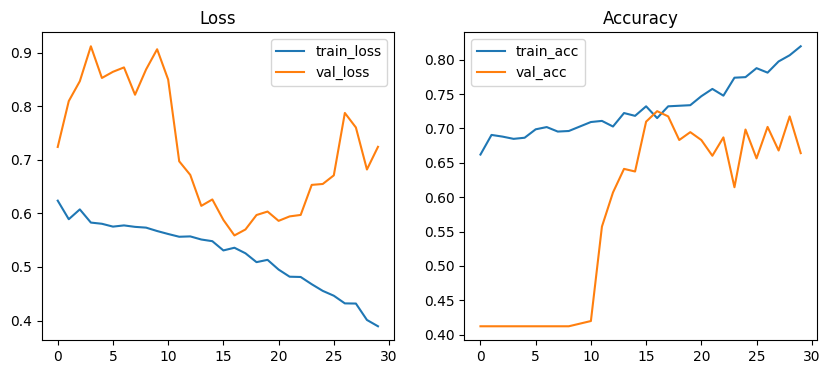

Loading test predictions for Scenario 1...
Plotting Confusion Matrix for Scenario 1...


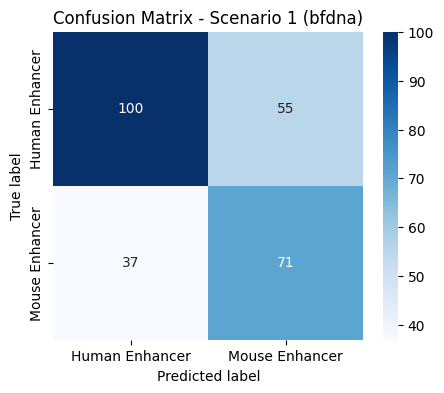

Plotting ROC Curve for Scenario 1...


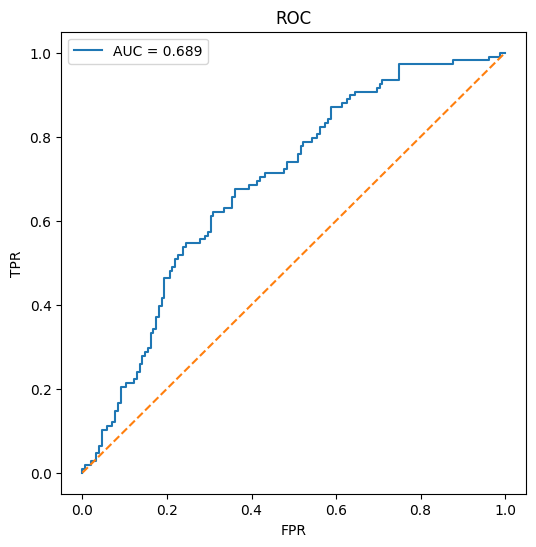


--- Plotting for Scenario 2 (bfdna encoder) ---
Plotting Training History for Scenario 2...


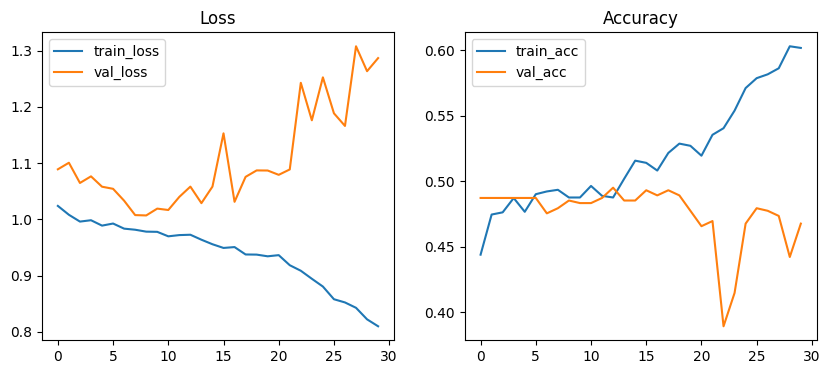

Loading test predictions for Scenario 2...
Plotting Confusion Matrix for Scenario 2...


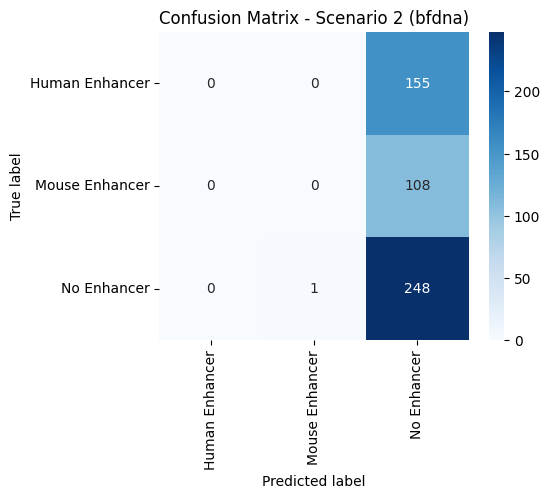

Note: Multi-class ROC curves require a specialized plotting function not provided in the helpers.


In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc

encoder_to_plot = 'bfdna'

# --- Scenario 1 Plots ---
print(f"\n--- Plotting for Scenario 1 ({encoder_to_plot} encoder) ---")
outdir_s1 = f"./outputs/{encoder_to_plot}/scenario1"

# Plot Training History for Scenario 1
print("Plotting Training History for Scenario 1...")
plot_training(history_csv_path=os.path.join(outdir_s1, "training_log.csv"), outpath=os.path.join(outdir_s1, "training_history.png"))

# Load test predictions for Scenario 1
print("Loading test predictions for Scenario 1...")
data_s1 = np.load(os.path.join(outdir_s1, "test_preds_and_truth.npz"))
y_true_s1 = data_s1['y_true']
y_pred_s1 = data_s1['y_pred']
y_pred_prob_s1 = data_s1['y_pred_prob']

# Plot Confusion Matrix for Scenario 1
print("Plotting Confusion Matrix for Scenario 1...")
cm_s1 = confusion_matrix(y_true_s1, y_pred_s1)
plot_confusion_matrix(cm_s1, classes=['Human Enhancer', 'Mouse Enhancer'], title=f'Confusion Matrix - Scenario 1 ({encoder_to_plot})', outpath=os.path.join(outdir_s1, "confusion_matrix.png"))

# Plot ROC Curve for Scenario 1
print("Plotting ROC Curve for Scenario 1...")
plot_roc_binary(y_true_s1, y_pred_prob_s1, outpath=os.path.join(outdir_s1, "roc_curve.png"))

# --- Scenario 2 Plots ---
print(f"\n--- Plotting for Scenario 2 ({encoder_to_plot} encoder) ---")
outdir_s2 = f"./outputs/{encoder_to_plot}/scenario2"

# Plot Training History for Scenario 2
print("Plotting Training History for Scenario 2...")
plot_training(history_csv_path=os.path.join(outdir_s2, "training_log.csv"), outpath=os.path.join(outdir_s2, "training_history.png"))

# Load test predictions for Scenario 2
print("Loading test predictions for Scenario 2...")
data_s2 = np.load(os.path.join(outdir_s2, "test_preds_and_truth.npz"))
y_true_s2 = data_s2['y_true']
y_pred_s2 = data_s2['y_pred']
y_pred_prob_s2 = data_s2['y_pred_prob']

# Plot Confusion Matrix for Scenario 2
print("Plotting Confusion Matrix for Scenario 2...")
# The number of classes for Scenario 2 are 3: 0 (human enhancer), 1 (mouse enhancer), 2 (no enhancer)
cm_s2 = confusion_matrix(y_true_s2, y_pred_s2)
class_names_s2 = ['Human Enhancer', 'Mouse Enhancer', 'No Enhancer']
plot_confusion_matrix(cm_s2, classes=class_names_s2, title=f'Confusion Matrix - Scenario 2 ({encoder_to_plot})', outpath=os.path.join(outdir_s2, "confusion_matrix.png"))

print("Note: Multi-class ROC curves require a specialized plotting function not provided in the helpers.")